# Классификация текстов


## Мультиклассовая классификация по вопросам о языках программирования на Stack Overflow


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from keras import layers
from keras import losses

## Sentiment analysis

This dataset is an extract from the public Stack Overflow dataset for use as a tutorial on tensorflow.org.

It contains the body of 16,000 posts on four languages (Java, Python, CSharp, and Javascript), which are equally divided into train and test.

The keywords "Java", "Python", "CSharp" and "JavaScript" have been replaced in each post by the word "BLANK" in order to increase the difficulty of this dataset in classification examples.


### Скачайте датасет


In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file(
    "stack_overflow_16k", url, untar=True, cache_dir=".", cache_subdir=".dataset"
)

dataset_dir = os.path.dirname(dataset)

In [3]:
os.listdir(dataset_dir)

['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [5]:
sample_file = os.path.join(train_dir, "python/0.txt")
with open(sample_file) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

### Загрузите датасет

Структура скаченного датасета

```
.dataset/
....test/
.......python/
..........0.txt
..........1.txt
.......javascript/
..........0.txt
..........1.txt
.......csharp/
..........0.txt
..........1.txt
.......java/
..........0.txt
..........1.txt
....train/
.......python/
..........0.txt
..........1.txt
.......javascript/
..........0.txt
..........1.txt
.......csharp/
..........0.txt
..........1.txt
.......java/
..........0.txt
..........1.txt
```


Используем `text_dataset_from_directory` для создания `tf.data.Dataset`.

Датасет уже поделен на train и test, но мы выделим train и validation set, используя деление 80:20.


In [21]:
batch_size = 32
seed = 42

raw_train_ds: tf.data.Dataset = tf.keras.utils.text_dataset_from_directory(
    ".dataset/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


Мы можем заметить, что в папке train 8,000 примеров, из которых 80% (6400) будут использованы для обучения.

Пример элементов датасета:


In [54]:
for text_batch, label_batch in raw_train_ds.take(1).as_numpy_iterator():
    for i in range(3):
        print("Body:", text_batch[i])
        print("Label:", label_batch[i])
        print()

Body: b'"confusing instance of not sure why when i make an instance as in 2 the complier fails and 3 succes..//instantiate class used to fill in new stock details.createstockcodedetails createstockdetailsinput = new createstockcodedetails();.createstockdetailsinput.createstockcodedetails(createnewstockcode); // (2).createstockdetailsinput.createstockdetails(createnewstockcode);  // (3)...when i name the constructor the same name as the class, it fails. why?..class createstockcodedetails extends jframe implements actionlistener {.    public void createstockdetails(string stockcode) {.        // this works   .    }.} .....class createstockcodedetails extends jframe implements actionlistener {.    public void createstockcodedetails(string stockcode) {.        // this fails. why?.    }.}"\n'
Label: 1

Body: b'"different output than expected i just started programming and right now i\'m stuck with a problem. i\'m wondering how if functions really work. ..a = [ 20.0, 8.0, 2.5 ].b = 4.if b &g

У нас есть Labels от 0 до 3. Используем class_names, чтобы просмотреть их.


In [55]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Создаем датасеты validation и test.


In [56]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    ".dataset/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [57]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    ".dataset/test", batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


### Подготовьте датасет


Стандартизация данных


In [58]:
def custom_standardization(input_data):
    return tf.strings.regex_replace(
        tf.strings.lower(input_data), "[%s]" % re.escape(
            string.punctuation), ""
    )

Создаем слой `TextVectorization`, который используется для стандартизации, токенизации и векторизации данных.


In [61]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [62]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Посмотрим пример векторного представления


In [63]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [69]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_post, first_label = text_batch[0], label_batch[0]
print("Post", first_post)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized post", vectorize_text(first_post, first_label))

Post tf.Tensor(b'bubble sort without using temporary variable i want to sort both 1 dimensional and 2 dimensional array without using temp variable in blank..how to do it can anyone suggest\n', shape=(), dtype=string)
Label java
Vectorized post (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,  441,  203,   47, 3547,  116,    3,   46,    4,  441,  280,
          25, 3687,    8,   57, 3687,   82,  203,   47,  494,  116,    7,
        6854,    4,   40,   11,   35,  285, 1174,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

Посмотрим наш словарь


In [70]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  saw
 313 --->  source
Vocabulary size: 10000


Применим слой `TextVectorization` для ранее созданых датасетов train, validation и test


In [71]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Немного о вопросах производительности

Используем chache и prefetch для оптимизации производительности

[data performance guide](https://www.tensorflow.org/guide/data_performance).


In [72]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Создайте объект модели

It's time to create your neural network:


In [128]:
embedding_dim = 16

In [129]:
model = tf.keras.Sequential(
    [
        layers.Embedding(max_features + 1, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(4),
    ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_16 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_8   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

### Функция потерь и метод оптимизации

Используем функцию потерь, подходящую для целочисленных меток классов: `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`.

Используем метрику `accuracy`.


In [130]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)

### Обучите модель

You will train the model by passing the `dataset` object to the fit method.


In [131]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 1.3774 - accuracy: 0.3431 - val_loss: 1.3644 - val_accuracy: 0.4850
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 1.3467 - accuracy: 0.4820 - val_loss: 1.3249 - val_accuracy: 0.5294
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 1.2965 - accuracy: 0.5430 - val_loss: 1.2670 - val_accuracy: 0.5788
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 1.2301 - accuracy: 0.5798 - val_loss: 1.1974 - val_accuracy: 0.6194
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 1.1565 - accuracy: 0.6248 - val_loss: 1.1256 - val_accuracy: 0.6700
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 1.0806 - accuracy: 0.6639 - val_loss: 1.0563 - val_accuracy: 0.6931
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 1.0112 - accuracy: 0.6969 - val_loss: 0.9932 - val_accuracy: 0.7188
Epoch 

### Оцените качество модели


In [132]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 0.8716 - accuracy: 0.7400
Loss:  0.8715820908546448
Accuracy:  0.7400000095367432


### Постройте графики точности и потерь по времени


In [133]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:


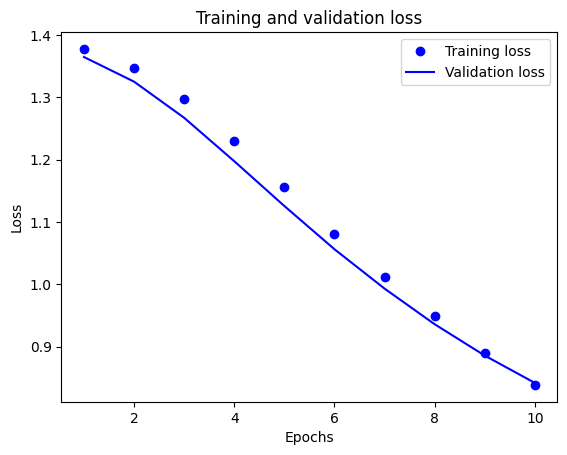

In [134]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

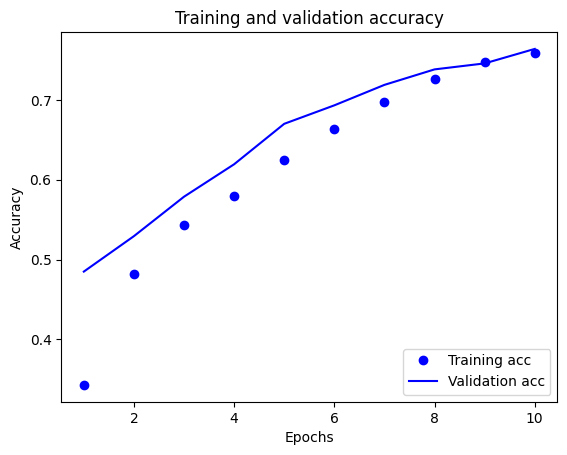

In [135]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

## Экспортируйте модель с дополнительным слоем подготовки данных


In [137]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model, layers.Activation("sigmoid")]
)

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 4s 13ms/step - loss: 0.8716 - accuracy: 0.7400
0.7400000095367432


### Осуществите предсказание на новых для модели данных

To get predictions for new examples, you can simply call `model.predict()`.


In [ ]:
examples = ["The movie was great!",
            "The movie was okay.", "The movie was terrible..."]

export_model.predict(examples)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.


## Больше о классификации текстов ...

...можно узнать тут: [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/).
Подходы с использованием ИНС (искуственных нейронных сетей): https://lena-voita.github.io/nlp_course/text_classification.html#neural_approaches


Лицензии, с которыми авторы используемого кода просят распространять его:

```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.
```

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
